In [2]:
import requests
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import time
import datetime
from datetime import datetime, date
from datetime import timedelta
import talib
import pickle
from scipy import stats
from datetime import datetime as dt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Imputer, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score,log_loss
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import lightgbm as lgb

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [145]:
from_date = date(2013,1,1)
to_date = date(2019,1,1)
to_date=datetime.now()

start= time.mktime(from_date.timetuple())
end = time.mktime(to_date.timetuple())

tickers = ['USDT_BTC','USDT_ETC','USDT_EOS','USDT_XMR','USDT_ETH','USDT_DASH','USDT_BAT','USDT_GNT',
 'USDT_XRP','USDT_LTC','USDT_XLM','USDT_REP','USDT_ZEC','USDT_IOT','USDT_NEO','USDT_BCH','USDT_TRX','USDT_OMG','USDT_XVG']#bitfinex

def get_data(date,coin):
    """ Query the API for 2000 days historical price data starting from "date". """
    url = "https://min-api.cryptocompare.com/data/histohour?fsym="+coin+"&tsym=USD&limit=1000&toTs={}".format(date)
    r = requests.get(url)
    ipdata = r.json()
    return ipdata

def get_hourly(date,coin, exchange=''):
    url = 'https://min-api.cryptocompare.com/data/histohour?fsym='+coin+'&tsym=USD&limit=999&toTs={}'\
            .format(date)
    if exchange:
        url += '&e={}'.format(exchange)
    page = requests.get(url)
    data = page.json()#['Data']
    #df = pd.DataFrame(data)
    #df['timestamp'] = [datetime.fromtimestamp(d) for d in df.time]
    return data


def get_df(from_date, to_date,coin):
    """ Get historical price data between two dates. """
    date = to_date
    holder = []
    # While the earliest date returned is later than the earliest date requested, keep on querying the API
    # and adding the results to a list. 
    while date > from_date:
        data = get_hourly(date,coin,exchange='Bitfinex')
        holder.append(pd.DataFrame(data['Data']))
        date = data['TimeFrom']
    # Join together all of the API queries in the list.    
    df = pd.concat(holder, axis = 0)                    
    # Remove data points from before from_date
    df = df[df['time']>from_date]                       
    # Convert to timestamp to readable date format
    df['time'] = pd.to_datetime(df['time'], unit='s')   
    # Make the DataFrame index the time
    df.set_index('time', inplace=True)                  
    # And sort it so its in time order 
    df.sort_index(ascending=True, inplace=True) 
    df.to_csv("1h_"+coin + '.csv')
    print('Processed: ' + coin)
    return df


#for x in tickers:
   # get_df(start,end,x[5:])
    

In [63]:
#Includes Profit
def retrieve_symbol_name(coin,window):
    col=['date','close']
    ndf=pd.read_csv("1h_"+coin+'.csv',index_col='time')
    ndf=ndf.drop(["volumefrom"],axis=1)
    ndf.index=pd.to_datetime(ndf.index)
    df=pd.DataFrame()
    unique_dates=ndf.index.drop_duplicates(keep='first')
    for i in unique_dates:
        if len(ndf.loc[i])>2:
            df=df.append(ndf.loc[i])
        else:
            df=df.append(ndf.loc[i].iloc[1,:])
    df['%_change']=df['close'].pct_change()
    df['coin']=coin
    df['RSI']=talib.RSI(df['close'], timeperiod=window)
    df['RSI_10']=df['RSI'].rolling(10).mean()
    df['RSI_50']=df['RSI'].rolling(50).mean()
    df['RSI_up']= (df['RSI_10']> df['RSI_50']).astype(float)
    df['10_MA']=df['close'].rolling(10).mean()
    df['50_MA']=df['close'].rolling(50).mean()
    df['MA_up']= (df['10_MA']> df['50_MA']).astype(float)
    df['volume_10']=df['volumeto'].rolling(10).mean()
    df['volume_50']=df['volumeto'].rolling(50).mean()
    df['vol_up']= (df['volume_10']> df['volume_50']).astype(float)
    df['vol']=df['%_change'].rolling(30).var()
    df['50_vol']=df['vol'].rolling(50).mean()
    df['200_vol']=df['vol'].rolling(200).mean()
    close = df['close']
    high = df['high']
    low = df['low']
    df['ATR'] = talib.ATR(high, low, close, window)
    df['50_Std']=df['%_change'].rolling(50*6).std()
    df['rise']=(df['%_change']>2*df['50_Std']).astype(float)
    df['fall']=(df['%_change']<-2*df['50_Std']).astype(float)
    df['ADX'] = talib.ADX(high, low, close, window)
    macd, macdsignal, macdhist = talib.MACD(df['close'], fastperiod=12, slowperiod=26, signalperiod=9)
    df['MACD']=macd
    df['MACD_Hist']=macdhist
    df['MACD_Signal']=macdsignal
    df['MACD_Hist_change']= df['MACD_Hist'].pct_change()
    df['Hist_std']=df['MACD_Hist_change'].rolling(50*6).std()
    df['MACD_signal']=(df['MACD_Hist_change']>df['Hist_std']).astype(float)
    df.index=pd.to_datetime(df.index)
    df=df.dropna()
    hour=[]
    for i in df.index:
        hour.append(int(str(i)[11:13]))
    df['hour']=hour
    df['1_day_high']=df['high'].rolling(24).max()
    df['1_day_low']=df['low'].rolling(24).min()
    low=[]
    maxx=[]
    date=[]
    exit=[]
    for i in df.index:
        if i+timedelta(hours=24) < df.index[-1]:
            low.append(df['1_day_low'].loc[i+timedelta(hours=24)])
            maxx.append(df['1_day_high'].loc[i+timedelta(hours=24)])
            date.append(i)
            exit.append(df['close'].loc[i+timedelta(hours=24)])
    df2=[date,maxx,low,exit]
    df2=pd.DataFrame(df2)
    df2=df2.transpose()
    df2.columns=['date','1day_high','1day_low','exit']
    df2.index=df2['date']
    df2=df2.drop(['date'],axis=1)
    df=df.dropna()
    merged=df2.join(df,how='outer')
    merged=merged.dropna()
    merged=merged.drop(['1_day_high','1_day_low'],axis=1)
    merged['Pnl_Long']=((merged['exit']-merged['close'])/merged['close'])*100
    merged['Pnl_Short']=((-merged['exit']+merged['close'])/merged['close'])*100
    
    merged['exit']=pd.to_numeric(merged['exit'])
    merged['1day_high']=pd.to_numeric(merged['1day_high'])
    merged['1day_low']=pd.to_numeric(merged['1day_low'])
    merged['Pnl_Long']=pd.to_numeric(merged['Pnl_Long'])
    merged['Pnl_Short']=pd.to_numeric(merged['Pnl_Short'])
    return merged

def all_coins():
    start=time.time()
    df=retrieve_symbol_name('BTC',14)
    tickers = ['USDT_BTC','USDT_ETC','USDT_EOS','USDT_XMR','USDT_ETH','USDT_DASH','USDT_BAT','USDT_GNT','USDT_XRP','USDT_LTC','USDT_XLM','USDT_REP','USDT_ZEC','USDT_IOT','USDT_NEO','USDT_BCH','USDT_TRX','USDT_OMG','USDT_XVG']
    for x in tickers:
        df=df.append(retrieve_symbol_name(x[5:],14))
    df=df.sort_index()
    print ("Runtime is " +str(time.time()-start)+" seconds")
    return df
#df=all_coins()

#pickle the dataframe
filename = '1hr_df'
outfile = open(filename,'wb')
pickle.dump(df,outfile)
outfile.close()



In [3]:
filename = '1hr_df'
infile = open(filename,'rb')
df = pickle.load(infile)
infile.close()

In [6]:
def entry_filter(df):
    df3=df.loc[(df['RSI_up']<1)].copy()# basic entry signal
    #df3['max_return']=(-df3['1day_low']+df3['close'])/df3['close']
    df3['max_return']=(df3['1day_high']-df3['close'])/df3['close']
    df3['label']=(df3['max_return']>0.04).astype(int)#trying to identify trades who have bigger potential
    return df3

def entry_filter_v2(df):
    df3=df.loc[(df['RSI_up'] > 0)].copy()# & (df['MACD_Hist'] > 0)].copy()
    #df3['max_return']=(df3['1day_high']-df3['close'])/df3['close']
    #df3['label']=(df3['max_return']>0.02).astype(int)
    return df3

entry=entry_filter(df)


features=entry.columns[3:-4]
features=list(features)
features.remove('coin')

print('Percent of Target Trades:', entry.label.sum() / float(len(entry)))
len(entry)

Percent of Target Trades: 0.3820791590665905


180371

In [8]:

### Split the data into training, testing sets ### this should be random
train = entry[(pd.to_datetime(entry.index) < pd.to_datetime('2018-08-01')) & 
           (pd.to_datetime(entry.index) >= pd.to_datetime('2013-01-01'))]
test = entry[pd.to_datetime(entry.index) >= pd.to_datetime('2018-08-01')]
X_train = train.loc[:,features]
y_train = train.loc[:,'label']
X_test = test.loc[:,features]

y_test = test.loc[:,'label']
print('Length of Training Set: ' + str(len(train)))
print('Length of Testing Set: ' + str(len(test)))
    


Length of Training Set: 122047
Length of Testing Set: 58324


In [241]:
#optimise hyperparameters, choose set with lowesest log_logloss
log_losses={}
score=0
bs=1
bn=0
bd=0
bl=0
blr=0
bln=0
for n in range(300,600,100):
    for md in range(1,4):
        for mln in range(50,400,100):
            for nl in range(10,20,10):
                for lr in frange(.001,.01,.002):
                    param = {'max_depth':md, 'num_leaves':nl, 'learning_rate':lr, 'num_trees':n,'num_threads':-1,
         'min_data_in_leaf':mln, 'objective':'binary', 'metric':'binary_logloss','verbosity':-1}
                    data = lgb.Dataset(X_train, y_train)
                    bst=lgb.train(param, data)
                    y_pred=bst.predict(X_test)
                    sc=log_loss(y_test,y_pred)
                    log_losses[str(n)+'_'+str(md)+'_'+str(mln)+'_'+str(nl)+'_'+str(lr)]=sc
                    if sc<bs:
                        bs=sc
                        bn=n
                        bd=md
                        bl=nl
                        blr=lr
                        bln=mln
                        

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [242]:
def optimal_param(data):
    df=pd.DataFrame.from_dict(data,orient='index')
    df.columns=['score']
    df=df.reset_index()
    split = df["index"].str.split("_", n = 4, expand = True) 
    df=df.join(split,how='outer')
    df=df.iloc[:,1:]
    df.columns=['score','num_trees','max_depth','min_leaf_data','num_leaves','learning_rate']
    for i in range(1,6):
        df.iloc[:,i]=pd.to_numeric(df.iloc[:,i])
    df=df.round(4)
    df=df.sort_values(by=['score'])
    return df

opt=optimal_param(log_losses)
opt.head()

,score,num_trees,max_depth,min_leaf_data,num_leaves,learning_rate
114,0.6045,400,3,250,10,0.009
84,0.6045,400,2,50,10,0.009
143,0.6046,500,2,50,10,0.007
119,0.6048,400,3,350,10,0.009
173,0.6049,500,3,250,10,0.007


In [11]:
data = lgb.Dataset(X_train, y_train)
#param = {'max_depth':opt['max_depth'], 'num_leaves':opt['num_leaves'], 'learning_rate':opt['learning_rate'], 'num_trees':opt['num_trees'],'num_threads':-1,
         #'min_data_in_leaf':opt['min_leaf_data'], 'objective':'binary', 'metric':'binary_logloss','verbosity':-1}
param = {'max_depth':2, 'num_leaves':10, 'learning_rate':0.01, 'num_trees':400,'num_threads':-1,
         'min_data_in_leaf':50, 'objective':'binary', 'metric':'binary_logloss','verbosity':-1}
bst = lgb.train(param, data)
y_pred = bst.predict(X_test)

#pickle the decision rules
filename = 'forest'
outfile = open(filename,'wb')
pickle.dump(bst,outfile)
outfile.close()

'Predicted trades '+str((y_pred.sum())/len(test))+'  :  Actual trades '+str((test.label.sum())/len(test))

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


'Predicted trades 0.3536175374268939  :  Actual trades 0.36127494684863865'

In [12]:
trades = test.assign(pred = y_pred)
trades = trades[trades.pred >0.5]
trades['cpl'] = trades.Pnl_Long.cumsum()
test['cpl'] = test.Pnl_Long.cumsum()

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [13]:
log_loss(y_test,y_pred)

0.5806609156992452

In [23]:
def drawdowns(equity_curve):
    # Calculate the cumulative returns curve 
    # and set up the High Water Mark
    # Then create the drawdown and duration series
    hwm = [0]
    eq_idx = equity_curve.index
    drawdown = pd.Series(index = eq_idx)
    duration = pd.Series(index = eq_idx)

    # Loop over the index range
    for t in range(1, len(eq_idx)):
        cur_hwm = max(hwm[t-1], equity_curve[t])
        hwm.append(cur_hwm)
        drawdown[t]= hwm[t] - equity_curve[t]
        duration[t]= 0 if drawdown[t] == 0 else duration[t-1] + 1
    return drawdown.max()#, duration

def stats_v2(trades,y_pred,prob):
    trades = test.assign(pred = y_pred)
    trades = trades[trades.pred>prob]
    col=['Mean_Return','Std','Count','Total','Sharpe']
    df=[trades.Pnl.mean(),trades.Pnl.std(),len(trades),trades.Pnl.sum(),trades.Pnl.mean()/trades.Pnl.std()]
    df=pd.DataFrame(df)
    df=df.transpose()
    df.columns=col
    return df

def stats(trades,test,y_pred,prob,t):
    #trades = test.assign(pred = y_pred)
    trades = trades[trades.pred>prob]
    ret=trades.Pnl_Long
    neg=ret[ret<0]
    bench=test.Pnl_Long
    neg1=bench[bench<0]
    col=['Mean_Return','Std','Count','Total','Sharpe','Sortino','Calmar','1day_Calmar']
    df=[ret.mean(),ret.std(),len(trades),ret.sum(),ret.mean()/ret.std(),ret.mean()/neg.std(),trades.cpl.max()/drawdowns(trades.cpl),ret.mean()/abs(ret.min())]
    df1=[bench.mean(),bench.std(),len(test),bench.sum(),bench.mean()/bench.std(),ret.mean()/neg1.std(),test.cpl.max()/drawdowns(test.cpl),bench.mean()/abs(bench.min())]
    df1=pd.DataFrame(df1)
    df1=df1.transpose()
    df1.columns=col
    df=pd.DataFrame(df)
    df=df.transpose()
    df.columns=col
    if t=='base':
        df=df.append(df1)
        df.index=['ML','Basic']
    return df

def frange(x, y, jump):
    while x < y:
        yield x
        x += jump

def opt_prob():
    p=.5
    prob=[p]
    df=stats(trades,test,y_pred,p,'t')  
    for x in frange(.55,trades.pred.max(),.05):
        df=df.append(stats(trades,test,y_pred,x,'t'))
        prob.append(x)
    df.index=prob
    return df

#s=stats(trades,test,y_pred,.8,'base')

opt=opt_prob()
opt


,Mean_Return,Std,Count,Total,Sharpe,Sortino,Calmar,1day_Calmar
0.50,1.101261,7.824983,11546.0,12715.155692,0.140736,0.210613,3.003688,0.023959
0.55,1.134895,7.970589,8021.0,9102.990252,0.142385,0.207693,3.007084,0.024691
0.60,1.597444,8.095446,5216.0,8332.269615,0.197326,0.278556,3.007084,0.034754
0.65,2.450625,8.311207,2604.0,6381.428116,0.294858,0.367514,3.014965,0.053315
0.70,3.634282,8.251007,1288.0,4680.955136,0.440465,0.494378,2.982935,0.079067
0.75,6.089316,7.120099,495.0,3014.211391,0.855229,1.594667,3.336212,0.295133
0.80,7.099183,7.558568,113.0,802.207704,0.939223,1.480276,3.011281,0.587349


In [24]:
s=stats(trades,test,y_pred,.55,'base')
s

,Mean_Return,Std,Count,Total,Sharpe,Sortino,Calmar,1day_Calmar
ML,1.134895,7.970589,8021.0,9102.990252,0.142385,0.207693,3.007084,0.024691
Basic,0.304009,5.719904,58324.0,17730.994080,0.053149,0.275098,0.956153,0.006614


/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Original PnL - No ML


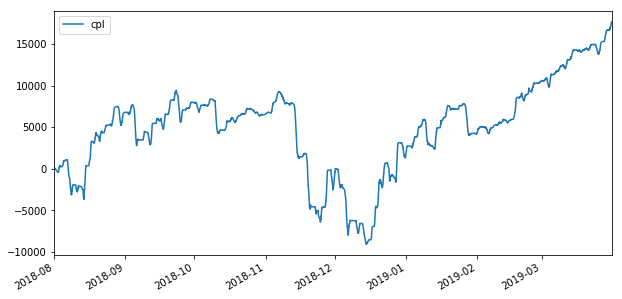

----------------
PnL with ML


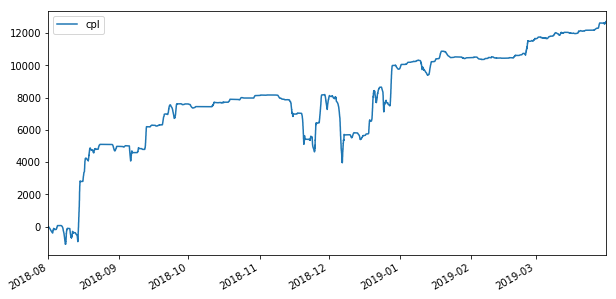

In [25]:
trades['cpl'] = trades.Pnl_Long.cumsum()

test['cpl'] = test.Pnl_Long.cumsum()
print('Original PnL - No ML')

test.plot(x=test.index,y='cpl',figsize=[10,5])
plt.show()
print('----------------')
print('PnL with ML')
trades.plot(x=trades.index,y='cpl',figsize=[10,5])
plt.show()

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Original PnL - No ML


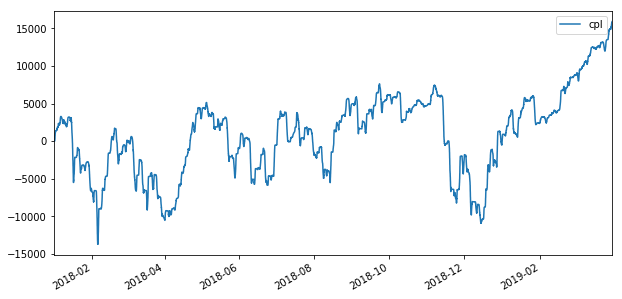

----------------
PnL with ML


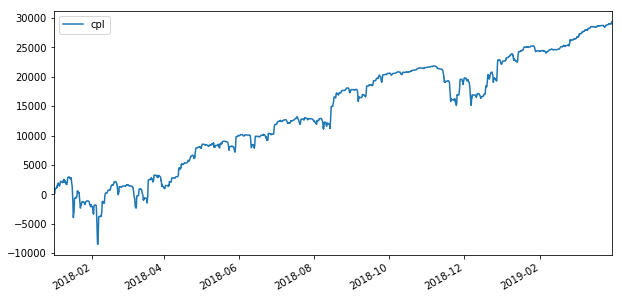

In [169]:
trades['cpl'] = trades.Pnl_Long.cumsum()

test['cpl'] = test.Pnl_Long.cumsum()
print('Original PnL - No ML')

test.plot(x=test.index,y='cpl',figsize=[10,5])
plt.show()
print('----------------')
print('PnL with ML')
trades.plot(x=trades.index,y='cpl',figsize=[10,5])
plt.show()

In [305]:
# Check type of each feature is float
print('Data Types:')
x=list(df.columns)
for i in x:
    t = df[i].dtype
    if t != float:
        print(i, t)
        x.remove(i)

Data Types:
1day_high float32
Pnl float32


In [287]:
daa=[]
for i in df.index:
    if str(type(df['Pnl'].loc[i])) !="<class 'numpy.float64'>":
        daa.append(i)
        

In [304]:
#df['1day_high']=pd.to_numeric(df['1day_high'],errors='coerce')
df['1day_high']=df['1day_high'].convert_objects(convert_numeric=True)

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  


In [290]:
type(df['Pnl'].loc[daa[0]])

numpy.float32

In [307]:
type(df['1day_high'][0])

numpy.float32

In [248]:

dates=[]
for i in d.index:
           if str(type(d.loc[i]['close']))!="<class 'numpy.float64'>":
            dates.append(i)
dates 

mylist = list(set(dates))#get unique values
mylist

[Timestamp('2015-02-22 20:00:00'),
 Timestamp('2015-02-22 20:00:00'),
 Timestamp('2015-04-05 11:00:00'),
 Timestamp('2015-04-05 11:00:00'),
 Timestamp('2015-05-17 02:00:00'),
 Timestamp('2015-05-17 02:00:00'),
 Timestamp('2015-06-27 17:00:00'),
 Timestamp('2015-06-27 17:00:00'),
 Timestamp('2015-08-08 08:00:00'),
 Timestamp('2015-08-08 08:00:00'),
 Timestamp('2015-09-18 23:00:00'),
 Timestamp('2015-09-18 23:00:00'),
 Timestamp('2015-10-30 14:00:00'),
 Timestamp('2015-10-30 14:00:00'),
 Timestamp('2015-12-11 05:00:00'),
 Timestamp('2015-12-11 05:00:00'),
 Timestamp('2016-01-21 20:00:00'),
 Timestamp('2016-01-21 20:00:00'),
 Timestamp('2016-03-03 11:00:00'),
 Timestamp('2016-03-03 11:00:00'),
 Timestamp('2016-04-14 02:00:00'),
 Timestamp('2016-04-14 02:00:00'),
 Timestamp('2016-05-25 17:00:00'),
 Timestamp('2016-05-25 17:00:00'),
 Timestamp('2016-07-06 08:00:00'),
 Timestamp('2016-07-06 08:00:00'),
 Timestamp('2016-08-16 23:00:00'),
 Timestamp('2016-08-16 23:00:00'),
 Timestamp('2016-09-